# RandomForest

- feature 나눠서 사용
- categorical 컬럼 라벨링
- price 컬럼 Standard Scaler 사용하여 정규화
- hyperparameter 튜닝 (max_depth=9, n_estimators=14)

## 라이브러리 & 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
# 전처리 끝낸 데이터 불러오기
raw = pd.read_csv('/Users/mac/AIFFEL/hackathon/new_musinsa(upcycling).csv', engine='python')
print(raw.shape)
raw.head()

(715, 12)


,Unnamed: 0,user,color,contents,category,ratings,gender,price,style,up_check,brand,url
0,0,멤버_464f9cc84f7d,기타,면,상의,5,남자,39000,0,0,119레오,https://www.musinsa.com/app/goods/1876547/0
1,1,멤버_464f9cc84f7d,카키,면,하의,5,남자,42000,0,0,119레오,https://www.musinsa.com/app/goods/2396824/0
2,2,멤버_464f9cc84f7d,기타,면,모자,5,남자,59000,0,0,119레오,https://www.musinsa.com/app/goods/2428013/0
3,3,멤버_464f9cc84f7d,블랙,면,상의,5,남자,35000,0,0,119레오,https://www.musinsa.com/app/goods/470357/0
4,4,멤버_464f9cc84f7d,아이보리,면 아라미드,가방,5,남자,48000,1,1,119레오,https://www.musinsa.com/app/goods/1766332/0


In [3]:
# 불필요한 컬럼 제거
raw.drop(['Unnamed: 0', 'user', 'up_check', 'url'], axis=1, inplace=True)
raw.head()

,color,contents,category,ratings,gender,price,style,brand
0,기타,면,상의,5,남자,39000,0,119레오
1,카키,면,하의,5,남자,42000,0,119레오
2,기타,면,모자,5,남자,59000,0,119레오
3,블랙,면,상의,5,남자,35000,0,119레오
4,아이보리,면 아라미드,가방,5,남자,48000,1,119레오


In [4]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   color     715 non-null    object
 1   contents  715 non-null    object
 2   category  715 non-null    object
 3   ratings   715 non-null    int64 
 4   gender    715 non-null    object
 5   price     715 non-null    int64 
 6   style     715 non-null    int64 
 7   brand     715 non-null    object
dtypes: int64(3), object(5)
memory usage: 44.8+ KB


## 라벨 인코딩

In [5]:
# 라벨 인코딩을 하기 위한 dictionary map 생성 함수
def make_label_map(dataframe):
    label_maps ={}
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            label_map = {'unknown':0}
            for i, key in enumerate(dataframe[col].unique()):
                label_map[key] = i+1  #새로 등장하는 유니크 값들에 대해 1부터 1씩 증가시켜 키값을 부여해줍니다.
            label_maps[col] = label_map
    return label_maps

In [6]:
# 각 범주형 변수에 인코딩 값을 부여하는 함수
def label_encoder(dataframe, label_map):
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            dataframe[col] = dataframe[col].map(label_map[col])
            dataframe[col] = dataframe[col].fillna(label_map[col]['unknown']) #혹시 모를 결측값은 unknown의 값(0)으로 채워줍니다.
    return dataframe

In [7]:
# train 데이터 라벨 인코딩
label_map = make_label_map(raw) # train 사용해 label map 생성
raw = label_encoder(raw, label_map) # train 라벨 인코딩

In [8]:
raw

,color,contents,category,ratings,gender,price,style,brand
0,1,1,1,5,1,39000,0,1
1,2,1,2,5,1,42000,0,1
2,1,1,3,5,1,59000,0,1
3,3,1,1,5,1,35000,0,1
4,4,2,4,5,1,48000,1,1
...,...,...,...,...,...,...,...,...
710,1,10,4,5,2,59000,0,6
711,4,63,3,5,2,35000,0,6
712,8,6,3,5,2,29000,0,6
713,3,3,1,5,2,138000,0,6


## target이 되는 brand 컬럼 분리

In [9]:
train_x = raw.drop(["brand"], axis=1)

In [10]:
train_x

,color,contents,category,ratings,gender,price,style
0,1,1,1,5,1,39000,0
1,2,1,2,5,1,42000,0
2,1,1,3,5,1,59000,0
3,3,1,1,5,1,35000,0
4,4,2,4,5,1,48000,1
...,...,...,...,...,...,...,...
710,1,10,4,5,2,59000,0
711,4,63,3,5,2,35000,0
712,8,6,3,5,2,29000,0
713,3,3,1,5,2,138000,0


## price 정규화

In [11]:
# price 정규화
num_features = ['price']

scaler = StandardScaler()
train_x[num_features] = scaler.fit_transform(train_x[num_features])
train_x.head()

,color,contents,category,ratings,gender,price,style
0,1,1,1,5,1,-0.385005,0
1,2,1,2,5,1,-0.352781,0
2,1,1,3,5,1,-0.170174,0
3,3,1,1,5,1,-0.427971,0
4,4,2,4,5,1,-0.288331,1


## feature 별 상관계수 확인

In [12]:
#%matplotlib inline   #쥬피터노트북에서 이미지 표시가능하게 하는 쥬피터노트북 매직함수
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:>

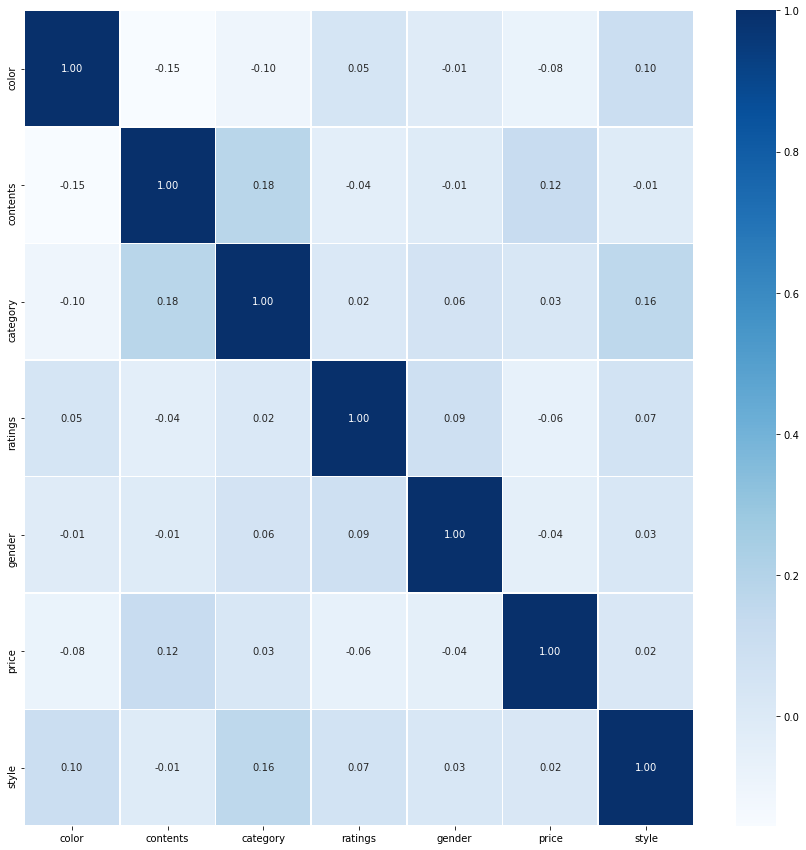

In [13]:
plt.figure(figsize=(15,15))
sns.heatmap(data = train_x.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

## 모델 학습

In [14]:
X_train, X_test, y_train, y_test = train_test_split(train_x, 
                                                    raw['brand'], 
                                                    test_size=0.2, 
                                                    random_state=4, 
                                                    stratify=raw.brand)

print('#Train set size: ', len(X_train))
print('#Test set size: ', len(X_test))

#Train set size:  572
#Test set size:  143


In [15]:
forest = RandomForestClassifier() # 분류기 선언
# train data를 이용해 분류기를 학습
forest.fit(X_train, y_train)

RandomForestClassifier()

In [16]:
# 먼저 점수를 메기는 방법인 평가 지표(Metric)를 정의합니다.
import numpy as np

def ACCURACY(true, pred):   
    score = np.mean(true==pred)
    return score

In [17]:
# 모델의 예측과 실제 정답값을 비교합니다.
prediction = forest.predict(X_test)

score = ACCURACY(y_test, prediction)

print(f"Random Forest 모델의 정확도는 {score*100:.2f}% 입니다")

Random Forest 모델의 정확도는 51.05% 입니다


In [18]:
# 오차행렬, 정확도, 정밀도, 재현율을 한번에 출력하기 위한 함수 정의
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score

pred = forest.predict(X_test)

def get_forest_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average='micro')
    recall = recall_score(y_test, pred, average='micro')
    print('Confusion Matrix')
    print(confusion)
    print('정확도:{}, 정밀도:{}, 재현율:{}'.format(accuracy, precision, recall))

In [19]:
get_forest_eval(y_test, pred)

Confusion Matrix
[[ 3  2  3  0  2  4]
 [ 1 19 10  1  1  6]
 [ 0  8 23  1  1  3]
 [ 0  1  2  2  0  1]
 [ 0  1  2  2  1  1]
 [ 4  6  4  2  1 25]]
정확도:0.5104895104895105, 정밀도:0.5104895104895105, 재현율:0.5104895104895105


In [20]:
# f1-score
f1 = f1_score(y_test, pred, average='micro')
print('f1 score :', f1)

f1 score : 0.5104895104895105


## Tuning

In [23]:
params = {'max_depth':range(1,11), 'min_samples_split':[2,3], 'n_estimators':range(1,16)}

In [24]:
from sklearn.model_selection import GridSearchCV
grid_rf_clf = GridSearchCV(estimator=forest, param_grid=params, cv=3,
                           scoring='accuracy', verbose=1, n_jobs=-1)

In [25]:
grid_rf_clf.fit(X_train, y_train)


Fitting 3 folds for each of 300 candidates, totalling 900 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(1, 11), 'min_samples_split': [2, 3],
                         'n_estimators': range(1, 16)},
             scoring='accuracy', verbose=1)

In [26]:
# GridSearchCV 결과 추출하여 DataFrame으로 변환
scores_df = pd.DataFrame(grid_rf_clf.cv_results_)
scores_df[['params', 'mean_test_score', 'rank_test_score', \
           'split0_test_score', 'split1_test_score', 'split2_test_score']]

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,"{'max_depth': 1, 'min_samples_split': 2, 'n_es...",0.300680,300,0.314136,0.298429,0.289474
1,"{'max_depth': 1, 'min_samples_split': 2, 'n_es...",0.342574,296,0.434555,0.298429,0.294737
2,"{'max_depth': 1, 'min_samples_split': 2, 'n_es...",0.414412,269,0.418848,0.366492,0.457895
3,"{'max_depth': 1, 'min_samples_split': 2, 'n_es...",0.379425,287,0.424084,0.303665,0.410526
4,"{'max_depth': 1, 'min_samples_split': 2, 'n_es...",0.437099,223,0.439791,0.413613,0.457895
...,...,...,...,...,...,...
295,"{'max_depth': 10, 'min_samples_split': 3, 'n_e...",0.524460,4,0.507853,0.549738,0.515789
296,"{'max_depth': 10, 'min_samples_split': 3, 'n_e...",0.472022,152,0.450262,0.497382,0.468421
297,"{'max_depth': 10, 'min_samples_split': 3, 'n_e...",0.503435,44,0.502618,0.539267,0.468421
298,"{'max_depth': 10, 'min_samples_split': 3, 'n_e...",0.527969,2,0.476440,0.581152,0.526316


In [27]:
print(grid_rf_clf.best_score_)
print(grid_rf_clf.best_estimator_)

0.5331863690640214
RandomForestClassifier(max_depth=7, min_samples_split=3, n_estimators=15)


In [36]:
# forest = RandomForestClassifier(max_depth=9, min_samples_split=3, n_estimators=14)

forest = RandomForestClassifier(max_depth=9, n_estimators=14) # 분류기 선언
# train data를 이용해 분류기를 학습
forest.fit(X_train, y_train)
# 모델의 예측과 실제 정답값을 비교합니다.
prediction = forest.predict(X_test)

score = ACCURACY(y_test, prediction)

print(f"Random Forest 모델의 정확도는 {score*100:.2f}% 입니다")

Random Forest 모델의 정확도는 56.64% 입니다


In [37]:
# f1-score
f1 = f1_score(y_test, prediction, average='micro')
print('f1 score :', f1)

f1 score : 0.5664335664335665


In [39]:
# 학습모델 저장
import joblib

joblib.dump(forest, './randomforest(tuning).pkl')

['./randomforest(tuning).pkl']